## Imports and Load + Split Data

In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import os


train_dataset = datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([      
                transforms.ToTensor(),           
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

subset_indices_train = np.load('indices_train.npy')
subset_indices_valid = np.load('indices_valid.npy')

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=SubsetRandomSampler(subset_indices_train)
)
val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=SubsetRandomSampler(subset_indices_valid)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True)

In [3]:
class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.norm = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.15)
        self.dropout2 = nn.Dropout2d(0.15)
        self.fc1 = nn.Linear(1600, 64)
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output
    
model = Net()
model.load_state_dict(torch.load('best_MNIST_Net.pt'))

<All keys matched successfully>

## Examples of Mistakes

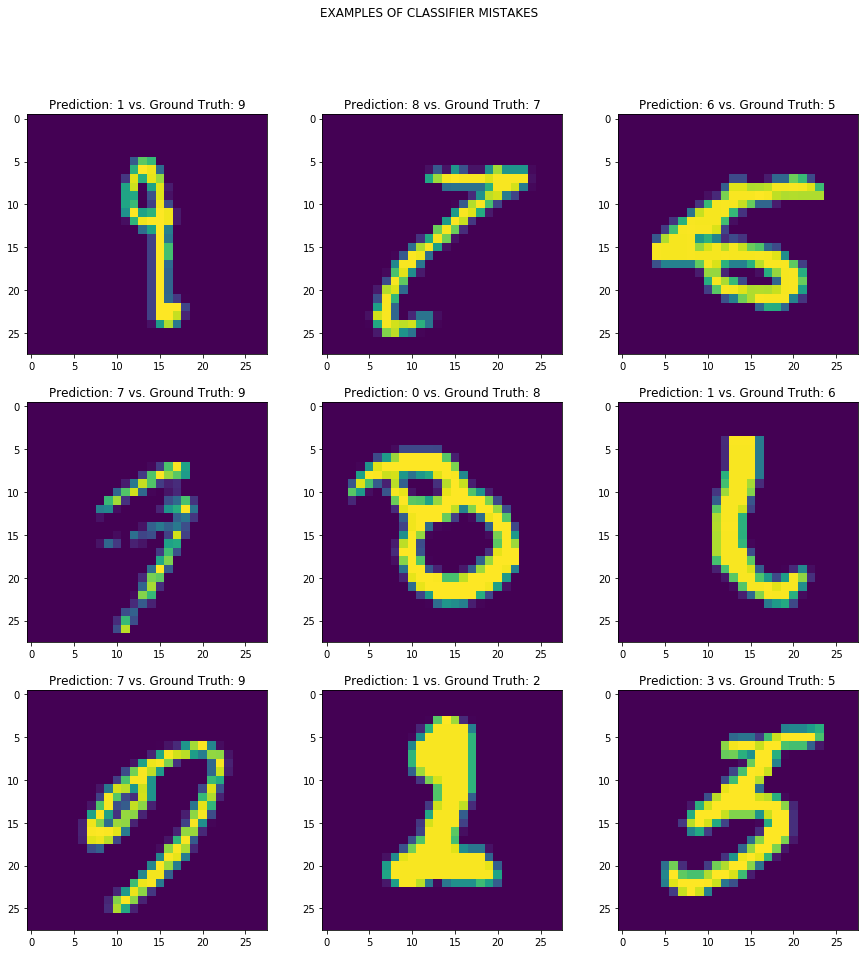

In [4]:
import matplotlib.pyplot as plt 

def mistakes(model, test_loader):
    model.eval()
    images = []
    prediction = []
    ground_truth = []
    with torch.no_grad():   
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            for i in range(len(data)):
                if pred[i] != target[i]:
                    images.append(data[i])
                    prediction.append(pred[i])
                    ground_truth.append(target[i])
                if (len(images) >= 10):
                    return images, prediction, ground_truth
                
images, prediction, ground_truth = mistakes(model, test_loader)

fig, axs = plt.subplots(3, 3, figsize=(15,15)) 
idx = 0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(images[idx][0])
        axs[i, j].set_title("Prediction: {} vs. Ground Truth: {}".format(prediction[idx][0], ground_truth[idx]))
        idx += 1
fig.suptitle("EXAMPLES OF CLASSIFIER MISTAKES")
plt.savefig("classifier_mistakes.png")

## Examples of Learned Kernels

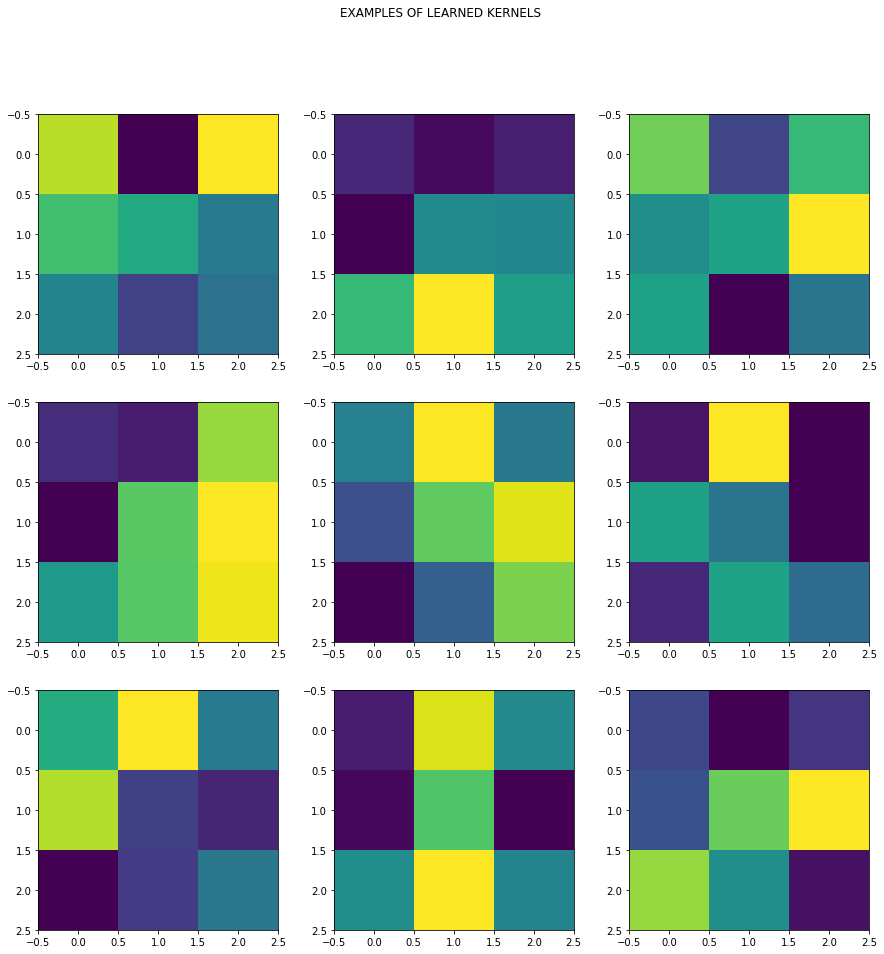

In [6]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE


def kernels(model):
    model.eval()
    layer = model.conv1
    weight_tensor = layer.weight.data
    return weight_tensor[:9]

weight_tensor = kernels(model)
                
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
idx = 0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(weight_tensor[idx][0])
        idx += 1
fig.suptitle("EXAMPLES OF LEARNED KERNELS")
plt.savefig("kernels.png")


## Generated Confusion Matrix

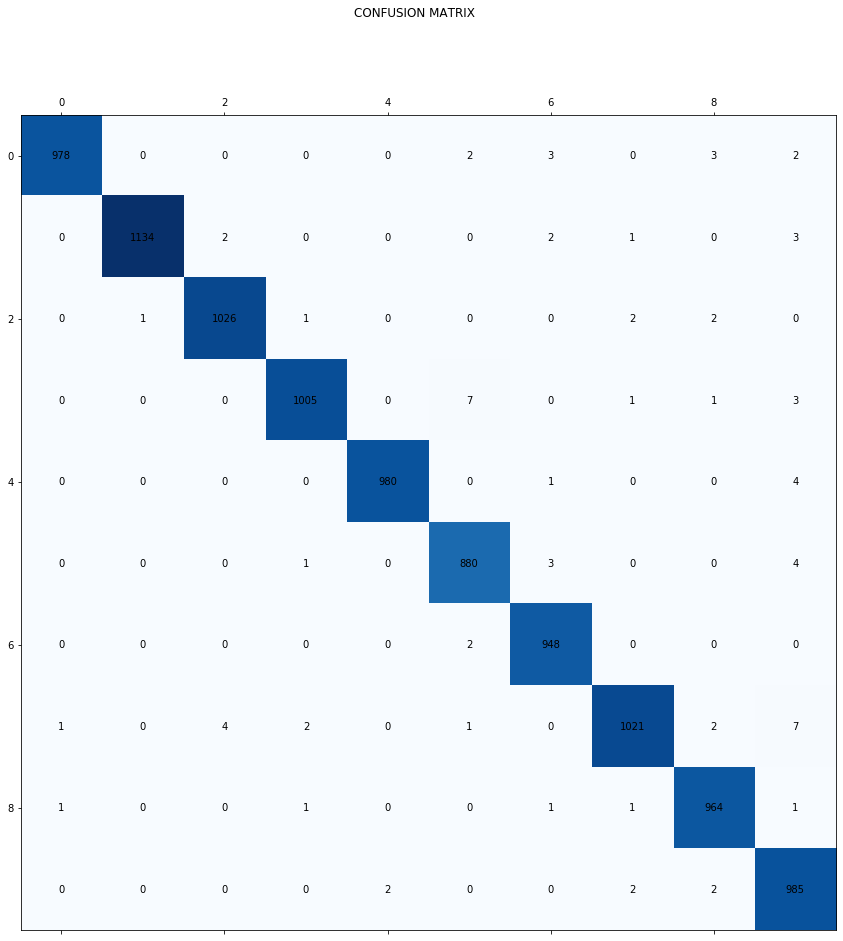

In [5]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_helper(model, test_loader):
    model.eval()  
    images = []
    prediction = []
    ground_truth = []
    with torch.no_grad():   
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            prediction.extend(pred)
            ground_truth.extend(target)
    return prediction, ground_truth

prediction, ground_truth = confusion_matrix_helper(model, test_loader)

plot = confusion_matrix(prediction, ground_truth)

fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(plot, cmap=plt.cm.Blues)
for i in range(10):
    for j in range(10):
        c = plot[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
        
fig.suptitle("CONFUSION MATRIX")
plt.savefig("confusion_matrix.png")

## Visualize High-Dimensional Embedding

In [6]:
from sklearn.manifold import TSNE

embeddings = []
def copy_data(m, i, o):
    embeddings.extend(o.data.numpy())
layer = model._modules.get('fc1')
feature_vector = layer.register_forward_hook(copy_data)

def embeddings_helper(model, test_loader):
    images = []
    prediction = []
    ground_truth = []
    model.eval()   
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            images.extend(data)
            prediction.extend(pred)
            ground_truth.extend(target)
    return images, prediction, ground_truth

images, prediction, ground_truth = embeddings_helper(model, test_loader)

feature_vector.remove()

embeddings2d = TSNE(n_components=2).fit_transform(embeddings)
np.save("embeddings.npy", embeddings2d)

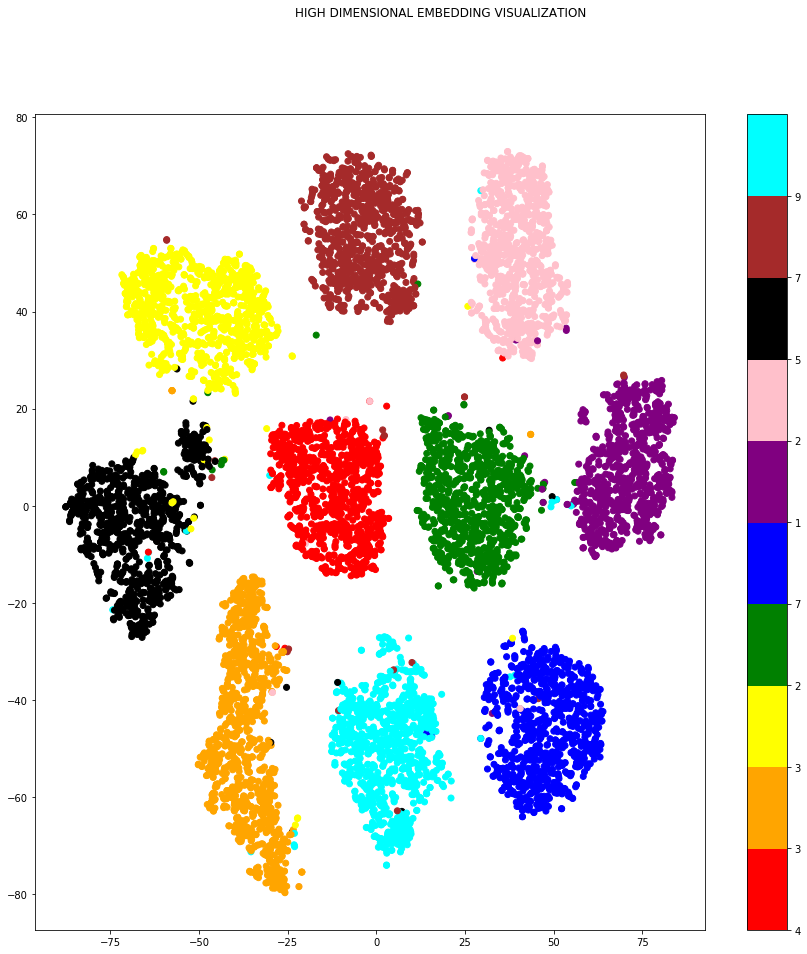

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

to_plot = zip(embeddings2d, ground_truth)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'black', 'brown', 'cyan']
x_coord = []
y_coord = []
digits = []
for point in to_plot:
    coord, digit = point
    x_coord.append(coord[0])
    y_coord.append(coord[1])
    digits.append(int(digit))

fig = plt.figure(figsize=(15,15))
plt.scatter(x_coord, y_coord, c=digits, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(digits),max(digits)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(digits)

fig.suptitle("HIGH DIMENSIONAL EMBEDDING VISUALIZATION")
plt.savefig("embedding_visualization.png")

## Find Closest Images by Feature Vectors

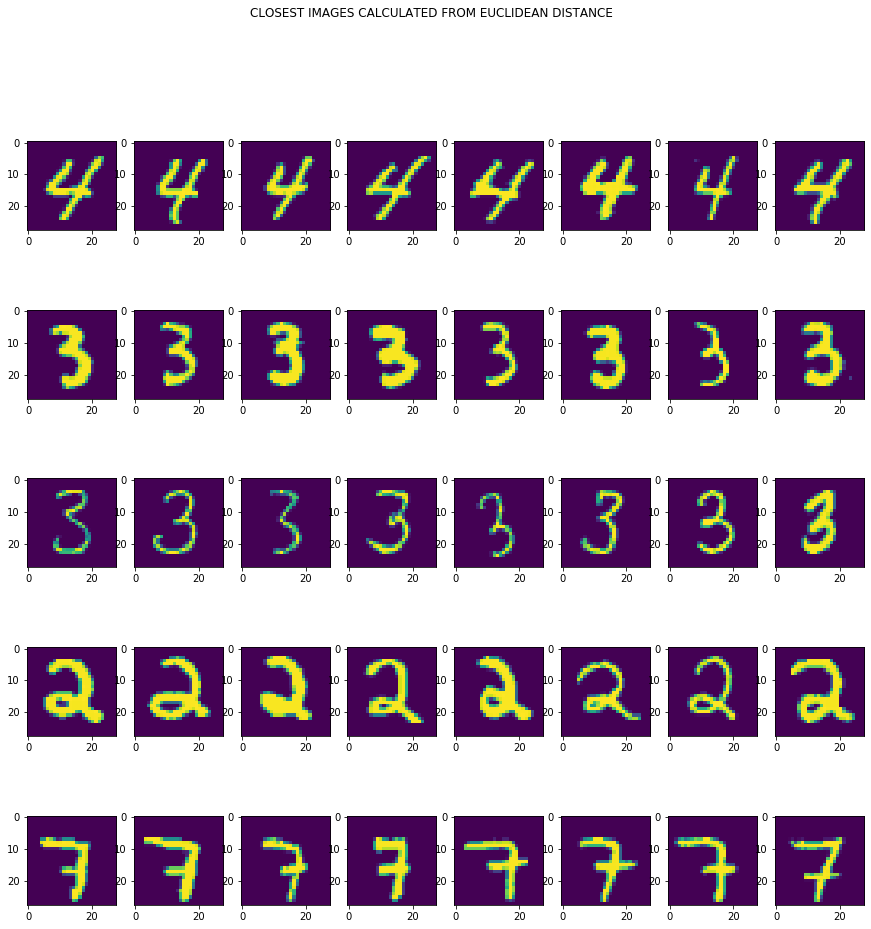

In [17]:
import numpy as np

def image_indices(images):
    indices = []
    for image in images:
        indices.append(image[1])
    return indices

all_indices = []
for i in range(5):
    embedding = embeddings[i]
    nearest_images = []
    for j in range(len(embeddings)):
        euclidean_distance = np.linalg.norm(embeddings[j] - embedding)
        nearest_images.append((euclidean_distance, j))
    nearest_images.sort(key = lambda x:x[0])
    nearest_images = nearest_images[:8]
    indices = image_indices(nearest_images)
    all_indices.append(indices)

fig, axs = plt.subplots(5, 8, figsize=(15, 15))
for i in range(5):
    for j in range(8):
        axs[i, j].imshow(images[all_indices[i][j]][0])
fig.suptitle("CLOSEST IMAGES CALCULATED FROM EUCLIDEAN DISTANCE")
plt.savefig("closest_images.png")